In [1]:
import sys
sys.path.append("./tacotron2/") # go to parent dir
# from customFunctions import *
sys.path.append("./waveglow/")

In [2]:
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd



In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', 
                       interpolation='none')

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.training_files = './tacotron2/filelists/vlsp/train.txt'

attention_dim: 128
attention_location_kernel_size: 31
attention_location_n_filters: 32
attention_rnn_dim: 1024
batch_size: 16
cudnn_benchmark: false
cudnn_enabled: true
decoder_rnn_dim: 1024
dist_backend: nccl
dist_url: tcp://localhost:54321
distributed_run: false
dynamic_loss_scaling: true
encoder_embedding_dim: 512
encoder_kernel_size: 5
encoder_n_convolutions: 3
epochs: 37
filter_length: 1024
fp16_run: false
gate_threshold: 0.5
grad_clip_thresh: 1.0
hop_length: 256
ignore_layers:
- embedding.weight
iters_per_checkpoint: 200
learning_rate: 0.001
load_mel_from_disk: false
mask_padding: true
max_decoder_steps: 1000
max_wav_value: 32768.0
mel_fmax: 8000.0
mel_fmin: 0.0
n_frames_per_step: 1
n_mel_channels: 80
n_symbols: 150
p_attention_dropout: 0.1
p_decoder_dropout: 0.1
postnet_embedding_dim: 512
postnet_kernel_size: 5
postnet_n_convolutions: 5
prenet_dim: 256
sampling_rate: 22050
seed: 1234
symbols_embedding_dim: 512
text_cleaners:
- flowtron_cleaners
training_files: filelists/vlsp/tra

In [5]:
checkpoint_path = "./tacotron2/checkpoints/checkpoint_52846"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [6]:
from waveglow.denoiser import Denoiser
waveglow_path = './waveglow/checkpoints/waveglow_62206'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
waveglow = waveglow.remove_weightnorm(waveglow)
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [7]:
from data_utils import TextMelLoader, TextMelCollate
trainset = TextMelLoader(hparams.training_files, hparams)

In [8]:
textx = "người ta thường hay nghĩ quá đáng * ngay cả trong trường hợp và bờ lô #"


In [9]:
inputs=trainset.get_text(
    textx
)
sequence = torch.autograd.Variable(
    inputs.unsqueeze(0)).cuda().long()
sequence.size()
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

In [10]:
sequence

tensor([[51, 40, 81, 66, 42,  0, 74,  6,  0, 74, 41, 81, 66, 51, 40,  0, 41,  6,
         89,  0, 51, 40, 41, 46,  0, 71, 75,  7,  0, 27,  7, 51, 40,  0,  4,  0,
         51, 40,  6, 89,  0, 25, 11,  0, 74, 72, 52, 51, 40,  0, 74, 72, 81, 66,
         51, 40,  0, 41, 67, 70,  0, 87,  8,  0, 24, 66,  0, 49, 58,  0, 99]],
       device='cuda:0')

In [11]:
# mel_outputs, mel_outputs_postnet, _, alignments

In [12]:
# trainset.text_embedding.symbol2numeric_dict
sequence.size()

torch.Size([1, 71])

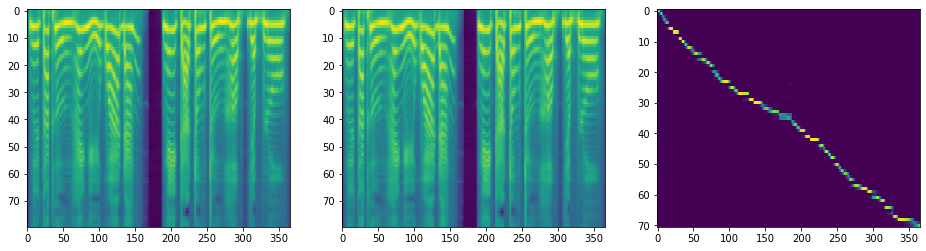

In [13]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [14]:
z=torch.mean(mel_outputs_postnet[0], dim=1).detach().cpu().numpy()
z

array([-3.926, -3.762, -3.729, -3.154, -2.174, -1.517, -1.578, -2.47 ,
       -3.27 , -3.604, -3.371, -3.271, -3.363, -3.47 , -3.418, -3.504,
       -3.588, -3.713, -3.89 , -4.062, -4.113, -4.066, -4.12 , -4.152,
       -4.305, -4.555, -4.727, -4.676, -4.637, -4.574, -4.6  , -4.707,
       -4.77 , -4.758, -4.77 , -4.812, -4.863, -4.832, -4.86 , -4.992,
       -5.074, -5.03 , -5.15 , -5.32 , -5.305, -5.234, -5.355, -5.46 ,
       -5.49 , -5.406, -5.434, -5.344, -5.22 , -5.3  , -5.168, -5.12 ,
       -5.094, -5.117, -5.29 , -5.36 , -5.387, -5.453, -5.38 , -5.473,
       -5.9  , -5.97 , -5.977, -6.008, -6.156, -6.305, -6.35 , -6.4  ,
       -6.49 , -6.695, -6.723, -6.594, -6.29 , -6.285, -6.375, -6.297],
      dtype=float16)

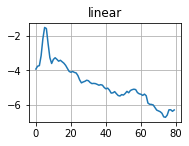

In [15]:
plt.subplot(221)
plt.plot(np.arange(z.shape[0]), z)
plt.yscale('linear')
plt.title('linear')
plt.grid(True)

In [28]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet,sigma=0.6)
# with torch.no_grad():
#     audio = waveglow.infer(z.unsqueeze(0).float().to("cuda").half(),sigma=1.)

In [29]:
# from waveglow.mel2samp import load_wav_to_torch
# z = load_wav_to_torch("./tacotron2/filelists/vlsp/wavs_train/07271.wav")
# au= z[0] / 32768.0
# print(au.size())

# with torch.no_grad():
#     ax = torch.autograd.Variable(au.cuda())
#     audio = waveglow((mel_outputs_postnet,ax))

In [30]:
# audio.half()
waveglow.n_remaining_channels, mel_outputs_postnet.size(2),audio.size()

(4, 365, torch.Size([1, 93440]))

In [31]:
388 * 4

1552

In [32]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
a = np.array(audio_denoised[0].data.cpu().numpy())


In [33]:
ipd.Audio(a, rate=hparams.sampling_rate, autoplay=False)

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import librosa
import IPython.display as ipd
a = np.array(audio[0].data.cpu().numpy())

a,index = librosa.effects.trim(a, top_db=40)
# ipd.Audio(a, rate=hparams.sampling_rate)

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
a = np.array(audio_denoised[0].data.cpu().numpy())

a,index = librosa.effects.trim(a, top_db=40)
ipd.Audio(a, rate=hparams.sampling_rate)

In [22]:
z=trainset.get_mel("./tacotron2/filelists/vlsp/wavs_train/07271.wav")

In [31]:
from waveglow.mel2samp import load_wav_to_torch
z = load_wav_to_torch("./tacotron2/filelists/vlsp/wavs_train/07271.wav")
audio = z[0] / 32768.0
audio

tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0001, -0.0001, -0.0003])

In [ ]:
from scipy.io.wavfile import write
# normalize audio for now
a = a/ np.abs(a).max()
# a = a[:hparams['sampling_rate'] * 3]
import os
write("./out.wav", hparams['sampling_rate'], a)

In [ ]:
a.astype(np.int16)

In [ ]:
librosa.output.write_wav('file_trim_5s.wav', a,hparams['sampling_rate'])

In [ ]:
hparams['sampling_rate']

In [ ]:
z=trainset.get_mel("./tacotron2/filelists/vlsp/wavs_train/07271.wav")

In [ ]:
z.unsqueeze(0).float().to("cuda")

In [ ]:
z -mel_outputs_postnet.squeeze(0)

In [ ]:
mel_outputs_postnet.size(),z.size()

In [ ]:
torch.mean(mel_outputs_postnet[0,:,:341].cpu() - z.cpu())

In [ ]:
torch.exp(z)